In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
# Verify that you have version 2 of tensorflow

tf.__version__

'2.1.0'

In [4]:

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [5]:
# Load the MNIST data

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [6]:
# Normalize the images to [-1, 1]

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [7]:
# Define the configs.

BUFFER_SIZE = 60000
BATCH_SIZE = 32

EPOCHS = 50
noise_dim = 128
num_examples_to_generate = 16

image_size = 28

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [8]:
type(train_images)

numpy.ndarray

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
class Generator():
    def __init__(self, input_dim):
        model = tf.keras.Sequential()
        model.add(layers.Dense(256, use_bias=False, input_shape=(input_dim,)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU()) # Default = 0.3


        model.add(layers.Dense(512, use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        #     print(model.output_shape)


        model.add(layers.Dense(1024, use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        #     print(model.output_shape)

        model.add(layers.Dense(784, use_bias=False, activation = 'tanh'))

        self.model = model

    def forward(self, x, training = False):
        return self.model(x, training = training)

In [10]:
class Discriminator():
    def __init__(self, input_dim):
        model = tf.keras.Sequential()
        model.add(layers.Dense(512, use_bias=True, input_shape=(input_dim,)))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))


        model.add(layers.Dense(256, use_bias=True))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))
        #     print(model.output_shape)


        model.add(layers.Dense(128, use_bias=True))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))
        #     print(model.output_shape)

        model.add(layers.Flatten())
        model.add(layers.Dense(1))

        self.model = model

    def forward(self, x, training = False):
        output = self.model(x, training = training)
        return output



tf.Tensor(
[[-0.11227747]
 [-0.0448477 ]
 [-0.29564476]
 [-0.29938954]], shape=(4, 1), dtype=float32)


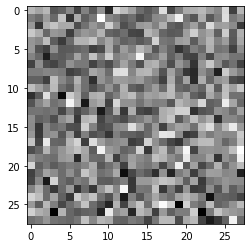

In [11]:
# Create an object of the Generator and the Discriminator

generator = Generator(noise_dim)
discriminator = Discriminator(image_size*image_size)


# Print a sample generator output before training the GAN.

noise = tf.random.normal([4, 128])
generated_image = generator.forward(noise, training=False)

img = tf.reshape(generated_image[0], (28, 28))

plt.imshow(img, cmap='gray')

decision = discriminator.forward(generated_image, training=False)
print (decision)

In [12]:
# Define the loss function.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
# Define the optimizers for Gen and Disc.

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
# Define the training step function - This is basically running one epoch.

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate some images from noise.
        generated_images = generator.forward(noise, training=True)

        # Find the discriminator output for real and fake images.
        real_output = discriminator.forward(images, training=True)
        fake_output = discriminator.forward(generated_images, training=True)

        # Compute the generator and discriminator losses.
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Find the gradients of both gen and disc.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.model.trainable_variables)

    # Use the optimizer to apply the gradients.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.model.trainable_variables))

In [17]:
# Define the main training function for the GAN.

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            image_batch = tf.reshape(image_batch, (BATCH_SIZE, image_size * image_size))
            train_step(image_batch)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))



In [18]:
train(train_dataset, EPOCHS)

Time for epoch 1 is 40.5778923034668 sec
Time for epoch 2 is 40.89944553375244 sec
Time for epoch 3 is 40.88352584838867 sec
Time for epoch 4 is 41.61582636833191 sec
Time for epoch 5 is 41.22470808029175 sec
Time for epoch 6 is 42.28378105163574 sec
Time for epoch 7 is 41.18620014190674 sec
Time for epoch 8 is 39.615450859069824 sec
Time for epoch 9 is 40.17325735092163 sec
Time for epoch 10 is 40.59689474105835 sec
Time for epoch 11 is 40.722835063934326 sec
Time for epoch 12 is 41.17563247680664 sec
Time for epoch 13 is 39.93512845039368 sec
Time for epoch 14 is 40.50039887428284 sec
Time for epoch 15 is 40.886343240737915 sec
Time for epoch 16 is 40.21212911605835 sec
Time for epoch 17 is 40.18646478652954 sec
Time for epoch 18 is 40.27297234535217 sec
Time for epoch 19 is 40.851290225982666 sec
Time for epoch 20 is 40.963605642318726 sec
Time for epoch 21 is 39.99441838264465 sec
Time for epoch 22 is 41.23888087272644 sec
Time for epoch 23 is 40.788397789001465 sec
Time for epoch 

In [19]:
# Generate images after training the model.

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [20]:
predictions = generator.forward(seed, training=False)

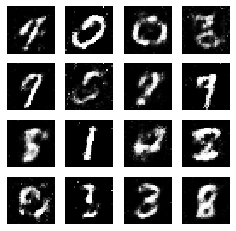

In [21]:
fig = plt.figure(figsize=(4,4))


for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.reshape(predictions[i], (28, 28)) * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
